In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sci
import matplotlib.image as mpimg
from scipy.stats import linregress
import mplcursors
import matplotlib.cm as cm
from matplotlib.colors import Normalize
%matplotlib inline

# Functions

In [2]:
def file_read_sw(fileName, path = ''):
    destination = path + fileName
    data = pd.read_csv(destination, sep='\s+')#delim_whitespace=True)
    data.columns = 'Year', 'DOY', 'HR', 'MN', 'Timeshift', 'Bx', 'By', 'Bz', 'Vx', 'Vy', 'Vz', 'Rho','Temp', 'P', 'AL'
    return data

def file_read_AL(fileName, path = ''):
    destination = path + fileName
    data = pd.read_fwf(destination, sep = '\s+', header = None)
    data.columns = ['Date', 'Time', 'DOY', 'AE', 'AU', 'AL', 'AO']
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.hour
    data['Min'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.minute
    data['Sec'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.second
    return data


def IAGA_file_read(fileName, path = ''):
    destination = path + fileName
    data = pd.read_fwf(destination, sep = '\t')
    data.columns = ['Date', 'Time', 'DOY', 'H', 'D', 'Z', 'F']
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.hour
    data['Min'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.minute
    data['Sec'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.second
    return data

def day(df):
    return df['DOY'] - 59

def IAGA_file_read2(fileName, path = ''):
    destination = path + fileName
    data = pd.read_fwf(destination, sep = '\t')
    data.columns = ['Date', 'Time', 'DOY', 'X', 'Y', 'Z', 'F']
    data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.hour
    data['Min'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.minute
    data['Sec'] = pd.to_datetime(data['Time'], format='%H:%M:%S.%f').dt.second
    return data
    
def bandpass_filter(data, min, max, fs, order=4): 
    low = 2*(min/fs)
    high = 2*(max/fs)
    b, a = sci.butter(order, [low, high], btype='band')
    ready = sci.filtfilt(b, a, data)
    return ready

def lowpass_filter(data, max, fs, order=4): 
    max = 2*(max/fs)
    b, a = sci.butter(order, max, btype='low')
    ready = sci.filtfilt(b, a, data)
    return ready

def isnan(df):
    if np.isnan(df):
        return 0
    else:
        return 1
    
def smooth(x):
    percentage = 0.005
    window_lengths = 51 #int(len(x)*percentage) # previously
    polyorders = 3
    amp_max1 = x.max()
    y = sci.savgol_filter(x, window_length=window_lengths, polyorder=polyorders, mode = 'interp')
    amp_max2 = y.max()
    factor = amp_max1/amp_max2
    y = y*factor
    return y

def count(df):
    if (df['MLT']*15 > 0) & (df['MLT']*15 <= 45):
        return 1
    elif (df['MLT']*15 > 45) & (df['MLT']*15 <= 90):
        return 2
    elif (df['MLT']*15 > 90) & (df['MLT']*15 <= 135):
        return 3
    elif (df['MLT']*15 > 135) & (df['MLT']*15 <= 180):
        return 4
    elif (df['MLT']*15 > 180) & (df['MLT']*15 <= 225):
        return 5
    elif (df['MLT']*15 > 225) & (df['MLT']*15 <= 270):
        return 6
    elif (df['MLT']*15 > 270) & (df['MLT']*15 <= 315):
        return 7
    else:
        return 8

# Overall Storm Features

### The Dst Index

In [3]:
dst = pd.read_csv('new.csv', header = None, names = ['hour', 'dst', 'time'])

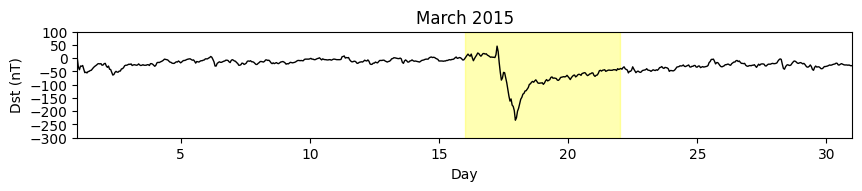

In [4]:
#%matplotlib qt
plt.figure(figsize = (10,8))
plt.subplot(5,1,1)
plt.plot(dst['time'], dst['dst'], linewidth = 1, c= 'black')
plt.axvspan(16, 22, color='yellow', alpha=0.3, label='Highlighted Region', edgecolor = None)
plt.xlim(1,31)
plt.ylabel('Dst (nT)')
plt.xlabel('Day')
plt.yticks([100, 50, 0, -50, -100, -150, -200, -250, -300])
plt.xticks([5,10,15,20,25,30])
mplcursors.cursor(hover=True);
plt.title('March 2015')
plt.savefig('C:\\Users\\Amal Marzooq\\Desktop\\first publication\\Plots\\dst\\dst all.png')
plt.show()

In [5]:
sw = file_read_sw('SW.txt')
sw['time'] = sw['HR'] + sw['MN']/60
sw['day'] = sw.apply(day, axis = 1)

sw['Bx'] = sw['Bx'].mask(sw['Bx'] >= 9999.99).interpolate('linear')
sw['By'] = sw['By'].mask(sw['By'] >= 9999.99).interpolate('linear')
sw['Bz'] = sw['Bz'].mask(sw['Bz'] >= 9999.99)#.interpolate('linear')
sw['Vx'] = sw['Vx'].mask(sw['Vx'] >= 99999.9).interpolate('linear')
sw['Vy'] = sw['Vy'].mask(sw['Vy'] >= 99999.9).interpolate('linear')
sw['Vz'] = sw['Vz'].mask(sw['Vz'] >= 99999.9).interpolate('linear')
sw['Rho'] = sw['Rho'].mask(sw['Rho'] >= 999.99).interpolate('linear')
sw['Temp'] = sw['Temp'].mask(sw['Temp'] >= 9999999.).interpolate('linear')
sw['P'] = sw['P'].mask(sw['P'] >= 99.99).interpolate('linear')
sw['AL'] = sw['AL'].mask(sw['AL'] >= 99999).interpolate('linear')

In [6]:
data_ASC = IAGA_file_read(fileName = 'data/ASC/asc20150317psec.txt')
data_GUA = IAGA_file_read(fileName = 'data/GUA/gua20150317vsec.txt')
data_DLT = IAGA_file_read2(fileName = 'data/DLT/dlt20150317qsec.txt')
data_KOU = IAGA_file_read2(fileName = 'data/KOU/kou20150317qsec.txt')

In [7]:
# Extracting the data of interest and reforming time:
myTable_ASC = pd.DataFrame()
myTable_ASC['tm'] = data_ASC['Sec']/3600 + data_ASC['Min']/60 + data_ASC['Hour']
myTable_ASC['H'] = data_ASC['H'] #np.sqrt(data['X']**2+data['Y']**2)  
myTable_ASC

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_ASC = myTable_ASC.mask(myTable_ASC > 80000)

myTable_ASC['H'] = myTable_ASC['H'] - myTable_ASC['H'].mean(skipna = True) #returns the mean while skipping nan values

#---------------------------------------------

myTable_GUA = pd.DataFrame()
myTable_GUA['tm'] = data_GUA['Sec']/3600 + data_GUA['Min']/60 + data_GUA['Hour']
myTable_GUA['H'] = data_GUA['H'] #np.sqrt(data['X']**2+data['Y']**2)  
myTable_GUA

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_GUA = myTable_GUA.mask(myTable_GUA > 80000)

myTable_GUA['H'] = myTable_GUA['H'] - myTable_GUA['H'].mean(skipna = True) #returns the mean while skipping nan values

#---------------------------------------------------

myTable_DLT = pd.DataFrame()
myTable_DLT['tm'] = data_DLT['Sec']/3600 + data_DLT['Min']/60 + data_DLT['Hour']
myTable_DLT['H'] = np.sqrt(data_DLT['X']**2+data_DLT['Y']**2)  
myTable_DLT

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_DLT = myTable_DLT.mask(myTable_DLT > 80000)

myTable_DLT['H'] = myTable_DLT['H'] - myTable_DLT['H'].mean(skipna = True) #returns the mean while skipping nan values

#----------------------------------------------------

myTable_KOU = pd.DataFrame()
myTable_KOU['tm'] = data_KOU['Sec']/3600 + data_KOU['Min']/60 + data_KOU['Hour']
myTable_KOU['H'] = np.sqrt(data_KOU['X']**2+data_KOU['Y']**2)  
myTable_KOU

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_KOU = myTable_KOU.mask(myTable_KOU > 80000)

myTable_KOU['H'] = myTable_KOU['H'] - myTable_KOU['H'].mean(skipna = True) #returns the mean while skipping nan values

In [8]:
start = 0
end = 24

duration_ASC = (myTable_ASC['tm'] > start) & (myTable_ASC['tm'] < end)
Bh_ASC = myTable_ASC['H'][duration_ASC]
tm_ASC = myTable_ASC['tm'][duration_ASC]
tm_ASC = tm_ASC.reset_index(drop=True)
Bh_ASC = Bh_ASC.interpolate('linear')
tm_ASC = tm_ASC.interpolate('linear')

duration_GUA = (myTable_GUA['tm'] > start) & (myTable_GUA['tm'] < end)
Bh_GUA = myTable_GUA['H'][duration_GUA]
tm_GUA = myTable_GUA['tm'][duration_GUA]
tm_GUA = tm_GUA.reset_index(drop=True)
Bh_GUA = Bh_GUA.interpolate('linear')
tm_GUA = tm_GUA.interpolate('linear')

duration_DLT = (myTable_DLT['tm'] > start) & (myTable_DLT['tm'] < end)
Bh_DLT = myTable_DLT['H'][duration_DLT]
tm_DLT = myTable_DLT['tm'][duration_DLT]
tm_DLT = tm_DLT.reset_index(drop=True)
Bh_DLT = Bh_DLT.interpolate('linear')
tm_DLT = tm_DLT.interpolate('linear')

duration_KOU = (myTable_KOU['tm'] > start) & (myTable_KOU['tm'] < end)
Bh_KOU = myTable_KOU['H'][duration_KOU]
tm_KOU = myTable_KOU['tm'][duration_KOU]
tm_KOU = tm_KOU.reset_index(drop=True)
Bh_KOU = Bh_KOU.interpolate('linear')
tm_KOU = tm_KOU.interpolate('linear')

### SW Parameters and Stations Plots

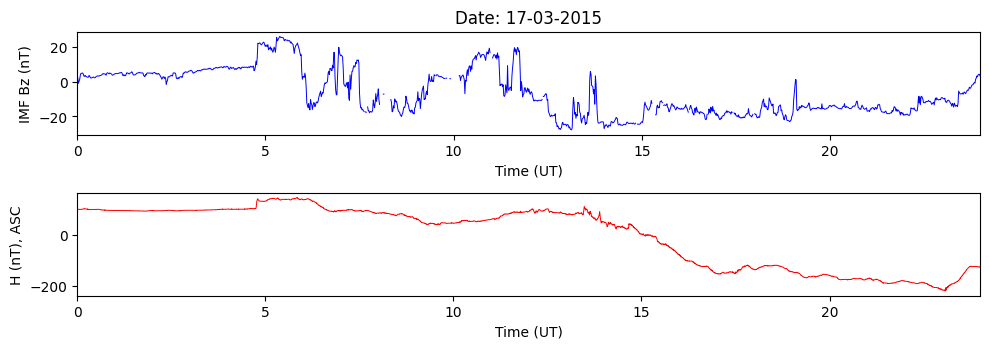

In [9]:
#%matplotlib qt
# Making sure the data is fine:
plt.figure(figsize=(10,8))


plt.subplot(5,1,1)
x = sw[sw['day'] == 17]['time']
y = sw[sw['day'] == 17]['Bz']
plt.plot(x,y, linewidth = 0.7, c = 'blue')
plt.xlim(0,max(x))
plt.xlabel('Time (UT)')
plt.ylabel('IMF Bz (nT)')
plt.title('Date: 17-03-2015')
mplcursors.cursor(hover=True);

#plt.subplot(5,1,1)
#x = sw[sw['day'] == 17]['time']
#y = sw[sw['day'] == 17]['Vz']
#plt.plot(x,y, linewidth = 0.7, c = 'red')
#plt.xlim(0,max(x))
#plt.xlabel('Time (UT)')
#plt.ylabel('Vz (km/s)')
#plt.title('Date: 17-03-2015')
#mplcursors.cursor(hover=True);


#plt.subplot(5,1,1)
#x = sw[sw['day'] == 17]['time']
#y = sw[sw['day'] == 17]['Vx']
#plt.plot(x,y, linewidth = 0.7, c = 'red')
#plt.xlim(0,max(x))
#plt.xlabel('Time (UT)')
#plt.ylabel('Vx (km/s)')
#plt.title('Date: 17-03-2015')
#mplcursors.cursor(hover=True);


#plt.subplot(5,1,1)
#x = sw[sw['day'] == 17]['time']
#y = sw[sw['day'] == 17]['Vy']
#plt.plot(x,y, linewidth = 0.7, c = 'red')
#plt.xlim(0,max(x))
#plt.xlabel('Time (UT)')
#plt.ylabel('Vy (km/s)')
#plt.title('Date: 17-03-2015')
#mplcursors.cursor(hover=True);

#plt.subplot(5,1,1)
#x = sw[sw['day'] == 17]['time']
#y = sw[sw['day'] == 17]['AL']
#plt.plot(x,y, linewidth = 0.7, c = 'red')
#plt.xlim(0,max(x))
#plt.xlabel('Time (UT)')
#plt.ylabel('AL (nT)')
#plt.title('Date: 17-03-2015')
#mplcursors.cursor(hover=True);


plt.subplot(5,1,2)
plt.plot(tm_ASC, Bh_ASC, 'r', linewidth = 0.7)
plt.xlabel('Time (UT)')
plt.ylabel('H (nT), ASC')
#plt.title('ASC')
plt.xlim(0,max(tm_ASC))
#plt.axvspan(4.5, 5.0, alpha = 0.5, color = '#FFFF00')


# plt.subplot(5,1,3)
# plt.plot(tm_GUA, Bh_GUA, 'blue', linewidth = 0.7)
# plt.xlabel('Time (UT)')
# plt.ylabel('H (nT), GUA')
# #plt.title('GUA')
# plt.xlim(0,max(tm_GUA))
# #plt.axvspan(4.5, 5.0, alpha = 0.5, color = '#FFFF00')

# plt.subplot(5,1,4)
# plt.plot(tm_DLT, Bh_DLT, 'blue', linewidth = 0.7)
# plt.xlabel('Time (UT)')
# plt.ylabel('H (nT), DLT')
# #plt.title('DLT')
# plt.xlim(0,max(tm_DLT))
# #plt.axvspan(4.5, 5.0, alpha = 0.5, color = '#FFFF00')

# plt.subplot(5,1,5)
# plt.plot(tm_KOU, Bh_KOU, 'blue', linewidth = 0.7)
# plt.xlabel('Time (UT)')
# plt.ylabel('H (nT), KOU')
# #plt.title('KOU')
# plt.xlim(0,max(tm_KOU))
# #plt.axvspan(4.5, 5.0, alpha = 0.5, color = '#FFFF00')


plt.tight_layout()
plt.savefig('C:\\Users\\Amal Marzooq\\Desktop\\first publication\\Plots\\Bz\\SSC Bz.png')
plt.show()

### The SSC Analysis

In [10]:
start = 4
end = 6

duration_ASC = (myTable_ASC['tm'] > start) & (myTable_ASC['tm'] < end)
Bh_ASC = myTable_ASC['H'][duration_ASC]
tm_ASC = myTable_ASC['tm'][duration_ASC]
tm_ASC = tm_ASC.reset_index(drop=True)
Bh_ASC = Bh_ASC.interpolate('linear')
tm_ASC = tm_ASC.interpolate('linear')

duration_GUA = (myTable_GUA['tm'] > start) & (myTable_GUA['tm'] < end)
Bh_GUA = myTable_GUA['H'][duration_GUA]
tm_GUA = myTable_GUA['tm'][duration_GUA]
tm_GUA = tm_GUA.reset_index(drop=True)
Bh_GUA = Bh_GUA.interpolate('linear')
tm_GUA = tm_GUA.interpolate('linear')

duration_DLT = (myTable_DLT['tm'] > start) & (myTable_DLT['tm'] < end)
Bh_DLT = myTable_DLT['H'][duration_DLT]
tm_DLT = myTable_DLT['tm'][duration_DLT]
tm_DLT = tm_DLT.reset_index(drop=True)
Bh_DLT = Bh_DLT.interpolate('linear')
tm_DLT = tm_DLT.interpolate('linear')

duration_KOU = (myTable_KOU['tm'] > start) & (myTable_KOU['tm'] < end)
Bh_KOU = myTable_KOU['H'][duration_KOU]
tm_KOU = myTable_KOU['tm'][duration_KOU]
tm_KOU = tm_KOU.reset_index(drop=True)
Bh_KOU = Bh_KOU.interpolate('linear')
tm_KOU = tm_KOU.interpolate('linear')

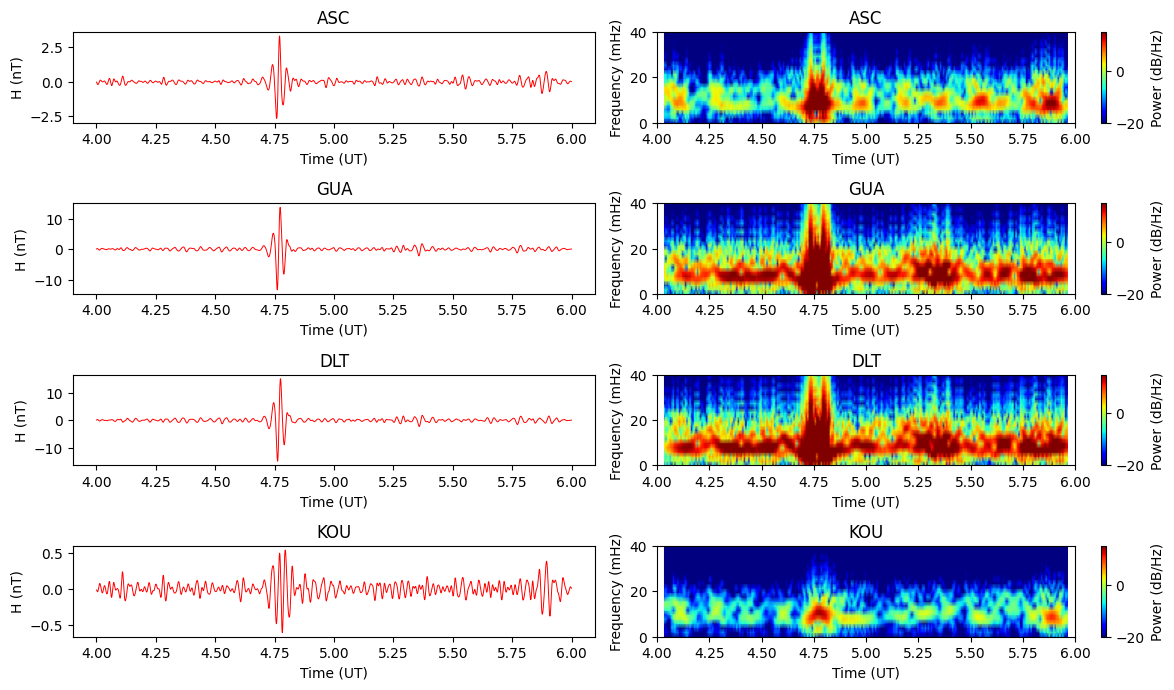

In [11]:
fs = 1
max = 0.0222
min = 0.00667
plt.figure(figsize=(12,10))

pi2_ASC = bandpass_filter(Bh_ASC, min, max, fs)

plt.subplot(6,2,1)
plt.plot(tm_ASC, pi2_ASC, linewidth=0.7, c = 'r')
plt.title('ASC')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')

plt.subplot(6,2,2)
nfft = 2**9
f,t,p = sci.spectrogram(pi2_ASC, fs = fs, nperseg = 2**8, noverlap = 0.45*nfft, nfft = nfft)
t = t/3600 + start
plt.pcolormesh(t, f*1000, 10*np.log10(p), shading='gouraud', cmap='jet')
plt.ylim(0,40)
plt.ylabel('Frequency (mHz)')
plt.xlabel('Time (UT)')
plt.colorbar(label='Power (dB/Hz)')
plt.xlim(4,6)
plt.clim(-20,15)
plt.title('ASC')


pi2_GUA = bandpass_filter(Bh_GUA, min, max, fs)

plt.subplot(6,2,3)
plt.plot(tm_GUA, pi2_GUA, linewidth=0.7, c = 'r')
plt.title('GUA')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')

plt.subplot(6,2,4)
nfft = 2**9
f,t,p = sci.spectrogram(pi2_GUA, fs = fs, nperseg = 2**8, noverlap = 0.45*nfft, nfft = nfft)
t = t/3600 + start
plt.pcolormesh(t, f*1000, 10*np.log10(p), shading='gouraud', cmap='jet')
plt.ylim(0,40)
plt.ylabel('Frequency (mHz)')
plt.xlabel('Time (UT)')
plt.colorbar(label='Power (dB/Hz)')
plt.clim(-20,15)
plt.xlim(4,6)
plt.title('GUA')

pi2_DLT = bandpass_filter(Bh_DLT, min, max, fs)

plt.subplot(6,2,5)
plt.plot(tm_DLT, pi2_DLT, linewidth=0.7, c = 'r')
plt.title('DLT')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')

plt.subplot(6,2,6)
nfft = 2**9
f,t,p = sci.spectrogram(pi2_DLT, fs = fs, nperseg = 2**8, noverlap = 0.45*nfft, nfft = nfft)
t = t/3600 + start
plt.pcolormesh(t, f*1000, 10*np.log10(p), shading='gouraud', cmap='jet')
plt.ylim(0,40)
plt.ylabel('Frequency (mHz)')
plt.xlabel('Time (UT)')
plt.colorbar(label='Power (dB/Hz)')
plt.clim(-20,15)
plt.xlim(4,6)
plt.title('DLT')

pi2_KOU = bandpass_filter(Bh_KOU, min, max, fs)

plt.subplot(6,2,7)
plt.plot(tm_KOU, pi2_KOU, linewidth=0.7, c = 'r')
plt.title('KOU')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')

plt.subplot(6,2,8)
nfft = 2**9
f,t,p = sci.spectrogram(pi2_KOU, fs = fs, nperseg = 2**8, noverlap = 0.45*nfft, nfft = nfft)
t = t/3600 + start
plt.pcolormesh(t, f*1000, 10*np.log10(p), shading='gouraud', cmap='jet')
plt.ylim(0,40)
plt.ylabel('Frequency (mHz)')
plt.xlabel('Time (UT)')
plt.colorbar(label='Power (dB/Hz)')
plt.clim(-20,15)
plt.xlim(4,6)
plt.title('KOU')

plt.tight_layout()
plt.savefig('C:\\Users\\Amal Marzooq\\Desktop\\first publication\\Plots\\SSC\\SSC.png')
plt.show()

# The Pi2 Signal

In [12]:
data_ASC = IAGA_file_read(fileName = 'data/ASC/asc20150316psec.txt')
data_GUA = IAGA_file_read(fileName = 'data/GUA/gua20150316vsec.txt')
data_DLT = IAGA_file_read2(fileName = 'data/DLT/dlt20150316qsec.txt')
data_KOU = IAGA_file_read2(fileName = 'data/KOU/kou20150316qsec.txt')

In [13]:
# Extracting the data of interest and reforming time:
myTable_ASC = pd.DataFrame()
myTable_ASC['tm'] = data_ASC['Sec']/3600 + data_ASC['Min']/60 + data_ASC['Hour']
myTable_ASC['H'] = data_ASC['H'] #np.sqrt(data['X']**2+data['Y']**2)  
myTable_ASC

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_ASC = myTable_ASC.mask(myTable_ASC > 80000)

myTable_ASC['H'] = myTable_ASC['H'] - myTable_ASC['H'].mean(skipna = True) #returns the mean while skipping nan values

#---------------------------------------------

myTable_GUA = pd.DataFrame()
myTable_GUA['tm'] = data_GUA['Sec']/3600 + data_GUA['Min']/60 + data_GUA['Hour']
myTable_GUA['H'] = data_GUA['H'] #np.sqrt(data['X']**2+data['Y']**2)  
myTable_GUA

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_GUA = myTable_GUA.mask(myTable_GUA > 80000)

myTable_GUA['H'] = myTable_GUA['H'] - myTable_GUA['H'].mean(skipna = True) #returns the mean while skipping nan values

#---------------------------------------------------

myTable_DLT = pd.DataFrame()
myTable_DLT['tm'] = data_DLT['Sec']/3600 + data_DLT['Min']/60 + data_DLT['Hour']
myTable_DLT['H'] = np.sqrt(data_DLT['X']**2+data_DLT['Y']**2)  
myTable_DLT

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_DLT = myTable_DLT.mask(myTable_DLT > 80000)

myTable_DLT['H'] = myTable_DLT['H'] - myTable_DLT['H'].mean(skipna = True) #returns the mean while skipping nan values

#----------------------------------------------------

myTable_KOU = pd.DataFrame()
myTable_KOU['tm'] = data_KOU['Sec']/3600 + data_KOU['Min']/60 + data_KOU['Hour']
myTable_KOU['H'] = np.sqrt(data_KOU['X']**2+data_KOU['Y']**2)  
myTable_KOU

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable_KOU = myTable_KOU.mask(myTable_KOU > 80000)

myTable_KOU['H'] = myTable_KOU['H'] - myTable_KOU['H'].mean(skipna = True) #returns the mean while skipping nan values

In [14]:
start = 2.5
end = 5

duration_ASC = (myTable_ASC['tm'] > start) & (myTable_ASC['tm'] < end)
Bh_ASC = myTable_ASC['H'][duration_ASC]
tm_ASC = myTable_ASC['tm'][duration_ASC]
tm_ASC = tm_ASC.reset_index(drop=True)
Bh_ASC = Bh_ASC.interpolate('linear')
tm_ASC = tm_ASC.interpolate('linear')

duration_GUA = (myTable_GUA['tm'] > start) & (myTable_GUA['tm'] < end)
Bh_GUA = myTable_GUA['H'][duration_GUA]
tm_GUA = myTable_GUA['tm'][duration_GUA]
tm_GUA = tm_GUA.reset_index(drop=True)
Bh_GUA = Bh_GUA.interpolate('linear')
tm_GUA = tm_GUA.interpolate('linear')

duration_DLT = (myTable_DLT['tm'] > start) & (myTable_DLT['tm'] < end)
Bh_DLT = myTable_DLT['H'][duration_DLT]
tm_DLT = myTable_DLT['tm'][duration_DLT]
tm_DLT = tm_DLT.reset_index(drop=True)
Bh_DLT = Bh_DLT.interpolate('linear')
tm_DLT = tm_DLT.interpolate('linear')

duration_KOU = (myTable_KOU['tm'] > start) & (myTable_KOU['tm'] < end)
Bh_KOU = myTable_KOU['H'][duration_KOU]
tm_KOU = myTable_KOU['tm'][duration_KOU]
tm_KOU = tm_KOU.reset_index(drop=True)
Bh_KOU = Bh_KOU.interpolate('linear')
tm_KOU = tm_KOU.interpolate('linear')

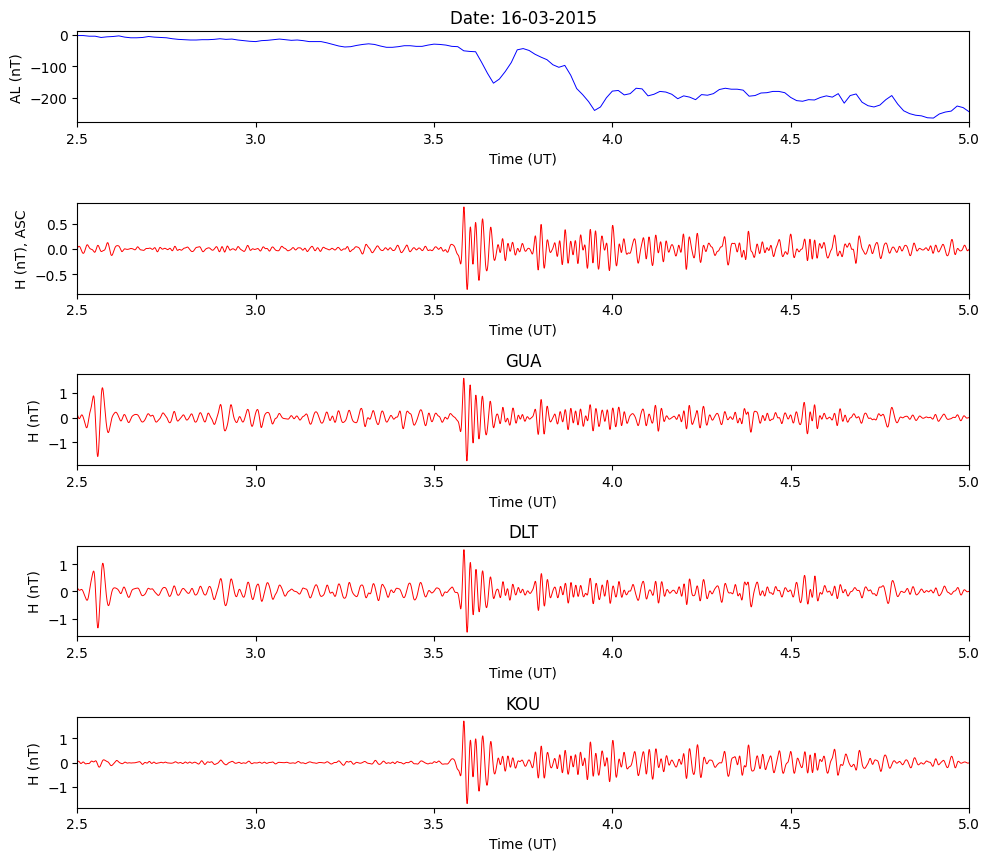

In [15]:
fs = 1
#%matplotlib qt
plt.figure(figsize=(10,10))

plt.subplot(6,1,1)
x = sw[(sw['day'] == 16)&(sw['time']>= start)&(sw['time']<=end)]['time']
y = sw[(sw['day'] == 16)&(sw['time']>= start)&(sw['time']<=end)]['AL']
plt.plot(x,y, linewidth = 0.7, c = 'blue')
plt.xlim(start,end)
plt.xlabel('Time (UT)')
plt.ylabel('AL (nT)')
plt.title('Date: 16-03-2015')
mplcursors.cursor(hover=True);

pi2_ASC = bandpass_filter(Bh_ASC, 0.00667, 0.025, fs)

plt.subplot(6,1,2)
plt.plot(tm_ASC, pi2_ASC, 'r', linewidth=0.7)
# plt.title('ASC')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT), ASC')
plt.xlim(start,end)
mplcursors.cursor(hover=True);

pi2_GUA = bandpass_filter(Bh_GUA, 0.00667, 0.025, fs)

plt.subplot(6,1,3)
plt.plot(tm_GUA, pi2_GUA, 'r', linewidth=0.7)
plt.title('GUA')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')
plt.xlim(start,end)
mplcursors.cursor(hover=True);


pi2_DLT = bandpass_filter(Bh_DLT, 0.00667, 0.025, fs)

plt.subplot(6,1,4)
plt.plot(tm_DLT, pi2_DLT, 'r', linewidth=0.7)
plt.title('DLT')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')
plt.xlim(start,end)
mplcursors.cursor(hover=True);


pi2_KOU = bandpass_filter(Bh_KOU, 0.00667, 0.025, fs)

plt.subplot(6,1,5)
plt.plot(tm_KOU, pi2_KOU, 'r', linewidth=0.7)
plt.title('KOU')
plt.xlabel('Time (UT)')
plt.ylabel('H (nT)')
plt.xlim(start,end)
mplcursors.cursor(hover=True);

plt.tight_layout()
plt.savefig('C:\\Users\\Amal Marzooq\\Desktop\\first publication\\Plots\\Pi2\\pi2-16-3-2015.png')
plt.show()

# MLT of Stations

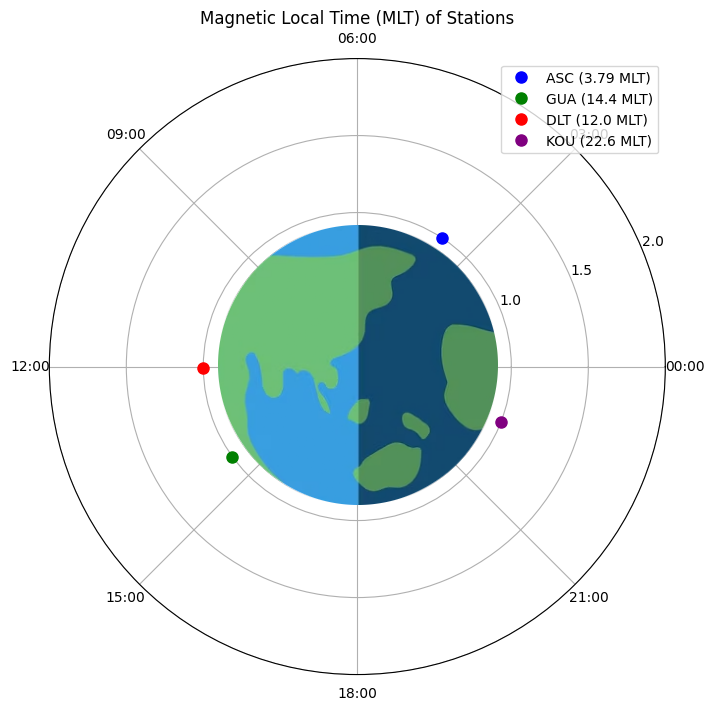

In [16]:
# Load the image
image = mpimg.imread('pictures/earth3.png')

i = 4.8
    
#for i in range(24):
sec = 0
min = 0
hour = i
UT = hour + min/60 + sec/3600
r = [1, 1, 1, 1]

N_pole = -72.649
ASC = 57.47
GUA = -143.51
DLT = -178.93
KOU = -20.46
long = [ASC, GUA, DLT, KOU]

MLT_ASC = (UT + ASC/15 + N_pole/15)
MLT_GUA = (UT + GUA/15 + N_pole/15)
MLT_DLT = (UT + DLT/15 + N_pole/15)
MLT_KOU = (UT + KOU/15 + N_pole/15)
MLT = [MLT_ASC, MLT_GUA, MLT_DLT, MLT_KOU]

theta = []
for i in MLT:
    if i > 24:
        theta.append(i - 24)
    elif i < 0:
        theta.append(i + 24)
    else:
        theta.append(i)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (8,8))
ax.set_theta_direction(1)
ax.plot(theta[0]*((15*np.pi)/180), r[0], 'o', markersize = 8, label = f'ASC ({theta[0]:.3} MLT)', c = 'blue')
ax.plot(theta[1]*((15*np.pi)/180), r[1], 'o', markersize = 8, label = f'GUA ({theta[1]:.3} MLT)', c = 'green')
ax.plot(theta[2]*((15*np.pi)/180), r[2], 'o', markersize = 8, label = f'DLT ({theta[2]:.3} MLT)', c = 'red')
ax.plot(theta[3]*((15*np.pi)/180), r[3], 'o', markersize = 8, label = f'KOU ({theta[3]:.3} MLT)', c = 'purple')
plt.legend()#bbox_to_anchor=(1.5, 1.1))
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])

ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False)) # ticks positions
ax.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00'])


# Set the position for the image
earth = fig.add_axes([0.338, 0.322, 0.35, 0.35], anchor='C', zorder=1) # [left, bottom, width, height]

earth.imshow(image)
earth.axis('off')

ax.set_title("Magnetic Local Time (MLT) of Stations")
plt.savefig('5-4.png')
plt.show()   

# Field-line Resonance Feature

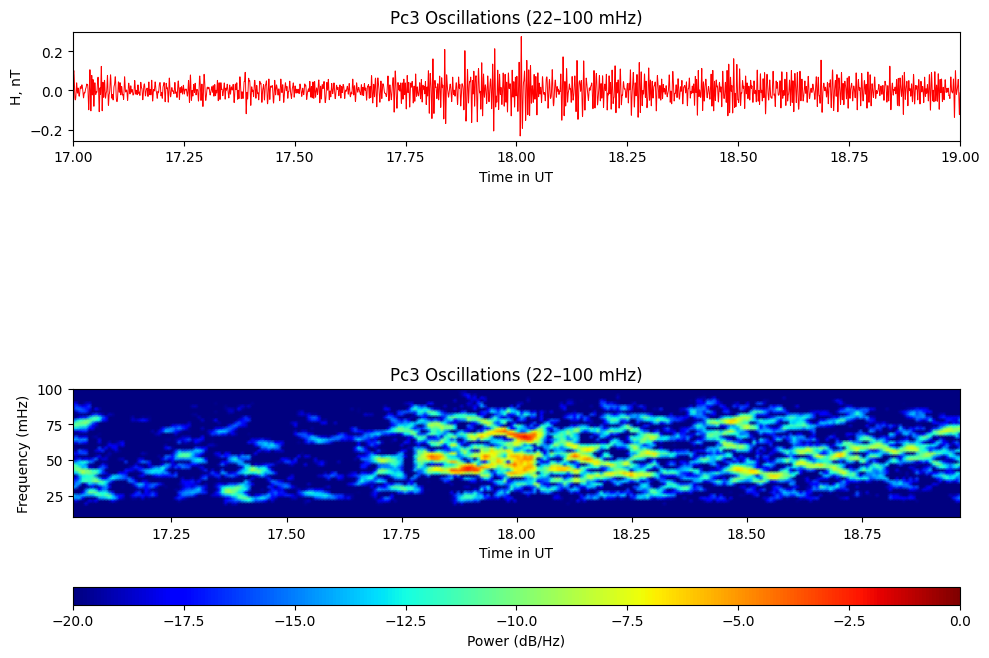

In [17]:
data = IAGA_file_read(fileName = 'data/ASC/asc20150316psec.txt')

# Extracting the data of interest and reforming time:
myTable = pd.DataFrame()
myTable['tm'] = data['Sec']/3600 + data['Min']/60 + data['Hour']
myTable['H'] =  data['H'] #np.sqrt(data['X']**2+data['Y']**2)
myTable

# Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
myTable = myTable.mask(myTable > 80000)

myTable['H'] = myTable['H'] - myTable['H'].mean(skipna = True) #returns the mean while skipping nan values

start = 17
end = 19
duration = (myTable['tm'] > start) & (myTable['tm'] < end)
Bh = myTable['H'][duration]
tm = myTable['tm'][duration]
tm = tm.reset_index(drop=True)
Bh = Bh.interpolate('linear')
tm = tm.interpolate('linear')

fs = 1
Bh = lowpass_filter(Bh, 0.1, fs)
# For Pc3 (22–100 mHz)
pc3 = bandpass_filter(Bh, 0.022, 0.1, fs)
#pc3 = smooth(pc3)

plt.figure(figsize=(10,10))

# Pc3 Signal
plt.subplot(6,1,1)
plt.plot(tm, pc3, 'r', linewidth=0.7)
plt.title('Pc3 Oscillations (22–100 mHz)')
plt.xlabel('Time in UT')
plt.ylabel('H, nT')
plt.xlim(start, end)

# Pc3 spectrogram:
plt.subplot(3,1,2)
fs = 1
nfft = 2**9
f,t,p = sci.spectrogram(pc3, fs = fs, nperseg = 2**8, noverlap = 0.45*nfft, nfft = nfft)
t = t/3600 + start
a = plt.pcolormesh(t, f*1000, 10*np.log10(p), shading='gouraud', cmap='jet')
plt.ylim(10,100)
plt.ylabel('Frequency (mHz)')
plt.xlabel('Time in UT')
#plt.colorbar(label='Power (dB/Hz)')
plt.clim(-20,0)
plt.title('Pc3 Oscillations (22–100 mHz)')

cbar = plt.colorbar(a, ax=plt.gca(), orientation='horizontal', pad=0.30, aspect = 50)
cbar.set_label('Power (dB/Hz)')

plt.tight_layout()
plt.savefig('resonance.png')
plt.show()

# The MLT Distribution of Pulsations

In [18]:
data = pd.read_csv("data/dataset.csv")
data['date'] = pd.to_datetime(data['date'])
data

,Unnamed: 0,date,type,amplitude,start(UT),end(UT),Middle(UT),Station code,latitude,longitude,...,SN,Bz,Vx,Vy,Vz,Rho,Temp,P,AL,MLT
0,0,2015-03-14,pc4,0.540,23.521,23.653,23.587,ASC,-2.73,57.47,...,55,1.381295,-462.652973,-11.241081,-10.874595,7.019135,99050.800000,2.552216,-151.029167,22.575067
1,1,2015-03-14,pc4,2.360,23.224,23.432,23.328,ASC,-2.73,57.47,...,55,0.996939,-471.225260,-14.555363,-10.767820,6.885952,100189.850694,2.567405,-165.655556,22.316067
2,2,2015-03-14,pc3,0.324,23.248,23.316,23.282,ASC,-2.73,57.47,...,55,0.886018,-472.438144,-12.882474,-11.036082,7.009175,100205.572917,2.605670,-172.183333,22.270067
3,3,2015-03-14,pc3,0.118,23.592,23.648,23.620,ASC,-2.73,57.47,...,55,1.391707,-465.023529,-10.842647,-10.832353,7.038382,99252.000000,2.548529,-146.733333,22.608067
4,4,2015-03-14,pc4,0.314,0.127,0.258,0.193,ASC,-2.73,57.47,...,55,0.943093,-477.306280,-14.042029,-10.124638,6.924928,118331.714976,2.734638,-129.883333,23.181067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1211,2015-03-17,pc5,2.350,18.466,19.268,18.867,KOU,14.27,-20.46,...,38,0.837840,-472.457562,-9.935930,-13.457195,7.385738,97548.487580,3.018863,-123.874830,12.659733
764,1214,2015-03-18,pc5,1.510,0.095,0.810,0.453,KOU,14.27,-20.46,...,41,0.808771,-472.023567,-14.674886,-9.603003,7.362002,109669.640511,2.786351,-125.316279,18.245733
765,1219,2015-03-18,pc5,1.210,14.242,14.566,14.404,KOU,14.27,-20.46,...,41,0.100464,-478.008933,-2.830521,-14.271464,7.632705,109517.077114,3.412084,-207.587719,8.196733
766,1220,2015-03-18,pc5,1.640,14.863,15.293,15.078,KOU,14.27,-20.46,...,41,0.708000,-466.993036,-3.253214,-15.526429,8.299607,101796.230357,3.543179,-197.837179,8.870733


In [19]:
data.groupby(['Station code'])['type'].count()

Station code
ASC    165
DLT    185
GUA    205
KOU    213
Name: type, dtype: int64

In [20]:
Quiet = data[(data['kp'] < 4) & (data['type'] != 'pi2') & (data['date'].dt.day <17 )]

In [21]:
Quiet.count()

Unnamed: 0      358
date            358
type            358
amplitude       358
start(UT)       358
end(UT)         358
Middle(UT)      358
Station code    358
latitude        358
longitude       358
day             358
kp              358
SN              358
Bz              358
Vx              358
Vy              358
Vz              358
Rho             358
Temp            358
P               358
AL              358
MLT             358
dtype: int64

C:\Users\Amal Marzooq\AppData\Local\Temp\ipykernel_10744\2883423712.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


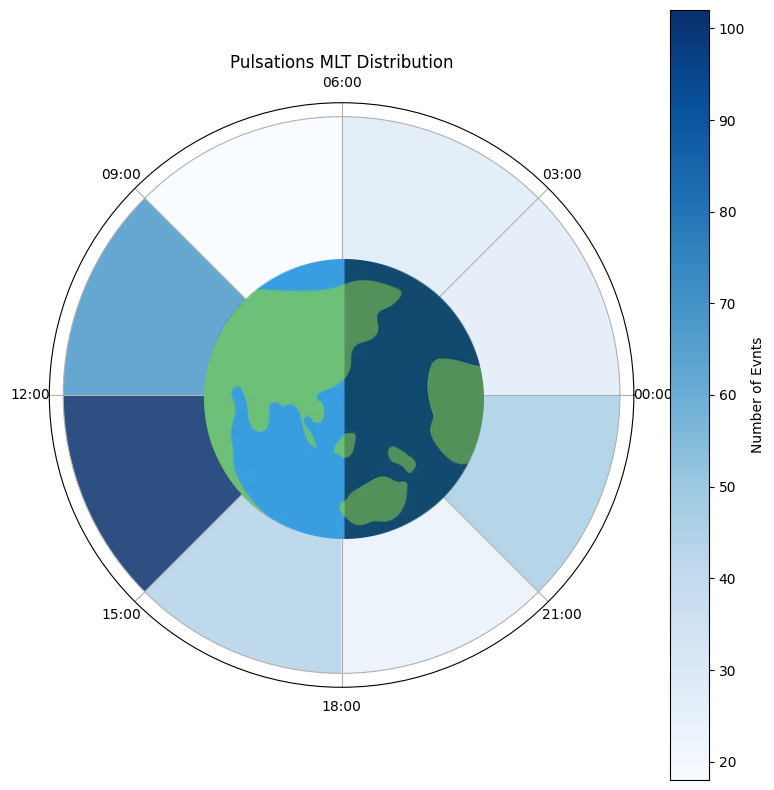

In [22]:
ang = Quiet.apply(count, axis = 1)
counts = ang.value_counts().sort_index(ascending=True)

angles = np.arange(0, 360, 45)

r = [2,2,2,2,2,2,2,2]

# Converting angles to radians for the polar plot
angles_rad = np.deg2rad(angles)

# Assigning counts for color intensity
norm = Normalize(vmin=np.min(counts), vmax=np.max(counts))
colors = cm.Blues(norm(counts)) 

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (8,8))
bars = ax.bar(angles_rad, r, color=colors, edgecolor='none', width=np.deg2rad(45), alpha=0.85, align='edge')


ax.set_rticks([2])
ax.set_yticklabels([])
ax.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False)) # ticks positions
ax.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00'])

# Setting the position for the image
earth = fig.add_axes([0.261, 0.32, 0.35, 0.35], anchor='C', zorder=1) # [left, bottom, width, height]

earth.imshow(image)
earth.axis('off')


# Adding a colorbar
sm = plt.cm.ScalarMappable(cmap=cm.Blues, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Number of Evnts") 

ax.set_title("Pulsations MLT Distribution")
plt.tight_layout()
plt.savefig('MLT distribution.png')
plt.show()

# The SW Parameters Scatter Plots

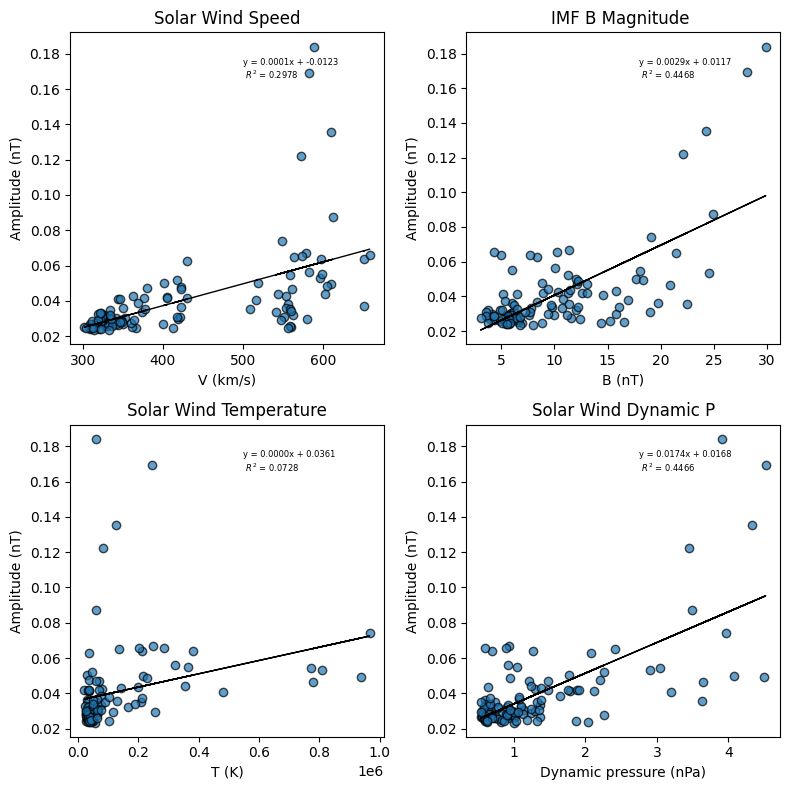

In [23]:
from scipy.signal import welch
seg = 3600
days = []
for i in range(1,8):
    days.append(i)

amplitudes = []
sw_velocity = []
sw_B = []
sw_T = []
sw_DP = []
sw_P = []
sw_R = []

days = [14, 15, 16, 17, 18]
for day in days:
    
    data_ASC = IAGA_file_read(fileName = f'data/ASC/asc201503{day}psec.txt')


    # Extracting the data of interest and reforming time:
    myTable_ASC = pd.DataFrame()
    myTable_ASC['tm'] = data_ASC['Sec']/3600 + data_ASC['Min']/60 + data_ASC['Hour']
    myTable_ASC['H'] = data_ASC['H'] #np.sqrt(data['X']**2+data['Y']**2)  
    myTable_ASC
    
    # Replace missing values (>= 8e4) with NaN -> IAGA standards: nulls are asigned the value 88888 or 99999:
    myTable_ASC = myTable_ASC.mask(myTable_ASC > 80000)
    
    myTable_ASC['H'] = myTable_ASC['H'] - myTable_ASC['H'].mean(skipna = True) #returns the mean while skipping nan values
    
    start = 0
    end = 24
    
    duration_ASC = (myTable_ASC['tm'] > start) & (myTable_ASC['tm'] < end)
    Bh_ASC = myTable_ASC['H'][duration_ASC]
    tm_ASC = myTable_ASC['tm'][duration_ASC]
    tm_ASC = tm_ASC.reset_index(drop=True)
    Bh_ASC = Bh_ASC.interpolate('linear')
    tm_ASC = tm_ASC.interpolate('linear')

    # Filtered data:
    fs = 1.0  # Sampling frequency (Hz)
    pc3_ASC = bandpass_filter(Bh_ASC, 0.022, 0.1, fs)
    pc4_ASC = bandpass_filter(Bh_ASC, 0.007, 0.022, fs)
    pc5_ASC = bandpass_filter(Bh_ASC, 0.002, 0.007, fs)
    
    time = tm_ASC
    signal = pc3_ASC
    tm = tm_ASC
    
    # Define frequency band for Pc3 waves
    f_min, f_max = 0.022, 0.1#
    
    # Segment signal into chunks for analysis
    interval_length = int(seg)  # 100-second intervals
    num_intervals = len(signal) // interval_length


    for i in range(num_intervals):
        
        start = i * interval_length
        end = start + interval_length
        segment = signal[start:end]
    #-------------------------------------------------------------------------------------------------------------------    
        # For solar wind velocity
        sw_velocity_avg_x = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Vx']).mean()
        sw_velocity_avg_y = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Vy']).mean()
        sw_velocity_avg_z = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Vz']).mean()
        sw_velocity_avg = np.sqrt(sw_velocity_avg_x**2 + sw_velocity_avg_y**2 + sw_velocity_avg_z**2)
        sw_velocity.append(sw_velocity_avg)
    
        # For IMF magnitude
        sw_Bx = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Bx']).mean(skipna = True)
        sw_By = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['By']).mean(skipna = True)
        sw_Bz = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Bz']).mean(skipna = True)
        sw_B_avg = np.sqrt(sw_Bx**2 + sw_By**2 + sw_Bz**2)
        sw_B.append(sw_B_avg)
    
        # For solar wind temperature
        sw_Temp = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Temp']).mean(skipna = True)
        sw_T.append(sw_Temp)
    
        # For solar wind dynamical pressure 
        sw_pressure = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['P']).mean(skipna = True)
        sw_DP.append(sw_pressure)
    
        # For pressure variation
        sw_Rho = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Rho']).mean(skipna = True)
        sw_Vx = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Vx']).mean(skipna = True)
        sw_pres = 0.5*sw_Rho*sw_Vx**2*1e-6 # (converted to nPa)
        sw_P.append(sw_pres)
    
        # For solar wind density
        sw_density = np.abs(sw[(sw['day'] == day)&(sw['time'] > tm[start])&(sw['time'] < tm[end])]['Rho']).mean(skipna = True)
        sw_R.append(sw_density)
        
     #--------------------------------------------------------------------------------------------------  

        frequencies, psd = welch(segment, fs, nperseg=2**9)
        
        # Integrate PSD over the desired frequency band
        band_indices = np.logical_and(frequencies >= f_min, frequencies <= f_max)
        wave_power = np.trapz(psd[band_indices], frequencies[band_indices])
        wave_amplitude = np.sqrt(wave_power)
        
        amplitudes.append(wave_amplitude)

#        # Compute FFT
#        fft_result = np.fft.fft(segment)
#        fft_freqs = np.fft.fftfreq(len(segment), d=1/fs)
#        
#        # Compute Power Spectral Density (PSD)
#        psd = np.abs(fft_result)**2 / len(segment)
#        
#        # Select frequency band for Pc4 waves
#        band_indices = (fft_freqs >= f_min) & (fft_freqs <= f_max)
#        wave_power = np.sum(psd[band_indices])  # Sum power in the band
#        
#        # Calculating the amplitude
#        amplitude = np.sqrt(wave_power)
#        amplitudes.append(amplitude)
#------------------------------------------------------------------------------------
df = pd.DataFrame()
df['amp'] = amplitudes
df['V'] = sw_velocity
df['B'] = sw_B
df['T'] = sw_T
df['DP']= sw_DP
df['P'] = sw_P
df['R'] = sw_R

#df = df[(df['amp'] > 0.3)&(df['amp'] < 10)]
df = df.dropna()

# Create scatter plot
plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)

# Fitting the data with a linear regression:
amp = np.array(df['amp'])
val = np.array(df['V'])
m, c, r_value, p_value, std = linregress(val, amp)
y = m*np.abs(val) + c

plt.scatter(val, amp, alpha=0.7, edgecolor='k')
plt.plot(val, y, color='black', label='Linear fit', linewidth = 1)

equation_text = f'y = {m:.4f}x + {c:.4f} \n $R^2$ = {r_value**2:.4f}'
plt.text(0.55, 0.85, equation_text, transform=plt.gca().transAxes, fontsize=6, color='black')
plt.xlabel('V (km/s)')
plt.ylabel('Amplitude (nT)')
plt.title('Solar Wind Speed')

plt.subplot(2,2,2)

# Fitting the data with a linear regression:
amp = np.array(df['amp'])
val = np.array(df['B'])
m, c, r_value, p_value, std = linregress(val, amp)
y = m*np.abs(val) + c

plt.scatter(val, amp, alpha=0.7, edgecolor='k')
plt.plot(val, y, color='black', label='Linear fit', linewidth = 1)

equation_text = f'y = {m:.4f}x + {c:.4f} \n $R^2$ = {r_value**2:.4f}'
plt.text(0.55, 0.85, equation_text, transform=plt.gca().transAxes, fontsize=6, color='black')
plt.xlabel('B (nT)')
plt.ylabel('Amplitude (nT)')
plt.title('IMF B Magnitude ')

plt.subplot(2,2,3)

# Fitting the data with a linear regression:
amp = np.array(df['amp'])
val = np.array(df['T'])
m, c, r_value, p_value, std = linregress(val, amp)
y = m*np.abs(val) + c

plt.scatter(val, amp, alpha=0.7, edgecolor='k')
plt.plot(val, y, color='black', label='Linear fit', linewidth = 1)

equation_text = f'y = {m:.4f}x + {c:.4f} \n $R^2$ = {r_value**2:.4f}'
plt.text(0.55, 0.85, equation_text, transform=plt.gca().transAxes, fontsize=6, color='black')
plt.xlabel('T (K)')
plt.ylabel('Amplitude (nT)')
plt.title('Solar Wind Temperature')

plt.subplot(2,2,4)

# Fitting the data with a linear regression:
amp = np.array(df['amp'])
val = np.array(df['P'])
m, c, r_value, p_value, std = linregress(val, amp)
y = m*np.abs(val) + c

plt.scatter(val, amp, alpha=0.7, edgecolor='k')
plt.plot(val, y, color='black', label='Linear fit', linewidth = 1)

equation_text = f'y = {m:.4f}x + {c:.4f} \n $R^2$ = {r_value**2:.4f}'
plt.text(0.55, 0.85, equation_text, transform=plt.gca().transAxes, fontsize=6, color='black')
plt.xlabel('Dynamic pressure (nPa)')
plt.ylabel('Amplitude (nT)')
plt.title('Solar Wind Dynamic P')

plt.tight_layout()
plt.savefig('sw parameters.png')
plt.show()